In [1]:
import numpy as np
import scipy
from hera_cal import io
from pyuvdata import UVData, UVCal
from hera_cal.datacontainer import DataContainer
from collections import OrderedDict as odict
from copy import deepcopy
import warnings
import uvtools
import argparse
from hera_cal.abscal import fft_dly
import gc as garbage_collector

In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook

# Generic Functions

In [3]:
def synthesize_ant_flags(flags):
    '''Conservatively synthesizes flags on visibilities into flags on antennas. Any flag at any time or
    frequency for visibility Vij is propagated to both antenna i and antenna j, unless that flag is
    due to either antenna i or antenna j being flagged for all times and all frequencies for all 
    visibilities that its involved in, in which case its flags are just applied to that antenna.

    Arguments:
        flags: DataContainer containing boolean data flag waterfalls

    Returns:
        ant_flags: dictionary mapping antenna-pol keys like (1,'x') to boolean flag waterfalls
    '''
    antpols = set([ap for (i,j,pol) in flags.keys() for ap in [(i, pol[0]), (j, pol[1])]])
    is_excluded = {ap: True for ap in antpols}
    for (i,j,pol), flags_here in flags.items():
        if not np.all(flags_here): 
            is_excluded[(i,pol[0])] = False
            is_excluded[(j,pol[1])] = False
    ant_flags = {}
    for (antpol) in antpols:
        if is_excluded[antpol]:
            ant_flags[antpol] = flags[(antpol[0], antpol[0], antpol[1]+antpol[1])]
    for (i,j,pol), flags_here in flags.items():
        if not is_excluded[(i,pol[0])] and not is_excluded[(j,pol[1])]:
            for antpol in [(i,pol[0]), (j,pol[1])]:
                if ant_flags.has_key(antpol):
                    ant_flags[antpol] = np.logical_or(ant_flags[antpol], flags_here)
                else:
                    ant_flags[antpol] = flags_here
    return ant_flags

In [4]:
def time_kernel(nInt, tInt, filter_scale=30.0):
    '''Build time averaging gaussian kernel.
    
    Arguments:
        nInt: number of integrations to be filtered
        tInt: length of integrations (minutes)
        filter_scale: float in minutes of FWHM of Gaussian smoothing kernel in time

    Returns:
        kernel: numpy array of length 2 * nInt + 1
    '''
    kernel_times = np.append(-np.arange(0,nInt*tInt+tInt/2,tInt)[-1:0:-1], np.arange(0,nInt*tInt+tInt/2,tInt))
    filter_std = filter_scale / (2*(2*np.log(2))**.5) 
    kernel = np.exp(-kernel_times**2/2/(filter_std)**2)
    return kernel / np.sum(kernel)


In [5]:
def time_filter(gains, wgts, times, filter_scale=30.0, nMirrors=0):
    '''Time-filter calibration solutions with a rolling Gaussian-weighted average. Allows
    the mirroring of gains and wgts and appending the mirrored gains and wgts to both ends, 
    ensuring temporal smoothness of the rolling average.
    
    Arguments:
        gains: ndarray of shape=(Ntimes,Nfreqs) of complex calibration solutions to filter
        wgts: ndarray of shape=(Ntimes,Nfreqs) of real linear multiplicative weights
        times: ndarray of shape=(Ntimes) of Julian dates as floats in units of days
        filter_scale: float in minutes of FWHM of Gaussian smoothing kernel in time
        nMirrors: Number of times to reflect gains and wgts (each one increases nTimes by 3)

    Returns:
        conv_gains: gains conolved with a Gaussian kernel in time
    '''
    
    padded_gains, padded_wgts = deepcopy(gains), deepcopy(wgts)
    nBefore = 0
    for n in range(nMirrors):
        nBefore += (padded_gains[1:,:]).shape[0]
        padded_gains = np.vstack((np.flipud(padded_gains[1:,:]),gains,np.flipud(padded_gains[:-1,:])))
        padded_wgts = np.vstack((np.flipud(padded_wgts[1:,:]),wgts,np.flipud(padded_wgts[:-1,:])))

    nInt, nFreq = padded_gains.shape
    conv_gains = padded_gains * padded_wgts
    conv_weights = padded_wgts
    kernel = time_kernel(nInt, np.median(np.diff(times))*24*60, filter_scale=filter_scale)
    for i in range(nFreq):
        conv_gains[:,i] = scipy.signal.convolve(conv_gains[:,i], kernel, mode='same')
        conv_weights[:,i] = scipy.signal.convolve(conv_weights[:,i], kernel, mode='same')
    conv_gains /= conv_weights
    conv_gains[np.logical_not(np.isfinite(conv_gains))] = 0
    return conv_gains[nBefore: nBefore+len(times), :]

In [6]:
def freq_filter(gains, wgts, freqs, filter_scale=10.0, tol=1e-09, window='tukey', skip_wgt=0.1, maxiter=100, **win_kwargs):
    '''Frequency-filter calibration solutions on a given scale in MHz using uvtools.dspec.high_pass_fourier_filter.
    Befor filtering, removes a per-integration delay using abscal.fft_dly, then puts it back in after filtering.
    
    Arguments:
        gains: ndarray of shape=(Ntimes,Nfreqs) of complex calibration solutions to filter 
        wgts: ndarray of shape=(Ntimes,Nfreqs) of real linear multiplicative weights
        freqs: ndarray of frequency channels in Hz
        filter_scale: frequency scale in MHz to use for the low-pass filter. filter_scale^-1 corresponds 
            to the half-width (i.e. the width of the positive part) of the region in fourier 
            space, symmetric about 0, that is filtered out. 
        tol: CLEAN algorithm convergence tolerance (see aipy.deconv.clean)
        window: window function for filtering applied to the filtered axis. 
            See aipy.dsp.gen_window for options.        
        skip_wgt: skips filtering rows with very low total weight (unflagged fraction ~< skip_wgt).
            filtered is left unchanged and info is {'skipped': True} for that time. 
            Only works properly when all weights are all between 0 and 1.
        maxiter: Maximum number of iterations for aipy.deconv.clean to converge.
        win_kwargs : any keyword arguments for the window function selection in aipy.dsp.gen_window.
            Currently, the only window that takes a kwarg is the tukey window with a alpha=0.5 default.


    Returns:
        filtered: filtered gains, ndarray of shape=(Ntimes,Nfreqs) 
        info: info object from uvtools.dspec.high_pass_fourier_filter
    '''
    sdf = np.median(np.diff(freqs)) / 1e9 #in GHz
    filter_size = (filter_scale / 1e3)**-1 #Puts it in ns
    (dlys, phi) = fft_dly(gains, wgts, df=sdf*1e9, medfilt=False) #delays are in seconds
    rephasor = np.exp(-2.0j * np.pi * np.outer(dlys, freqs))
    filtered, res, info = uvtools.dspec.high_pass_fourier_filter(gains*rephasor, wgts, filter_size, sdf, tol=tol, window=window, 
                                                                 skip_wgt=skip_wgt, maxiter=maxiter, **win_kwargs)
    filtered /= rephasor
    # put back in unfilted values if skip_wgt is triggered
    for i, info_dict in enumerate(info):
        if info_dict.get('skipped', False):
            filtered[i,:] = gains[i,:]
    return filtered, info

In [9]:
from hera_cal.io import polnum2str

def load_npz_flags(npzfile):
    '''Load flags from a npz file (like those produced by hera_qm.xrfi) and converts 
    them into a DataContainer. More than one spectral window is not supported. Assumes 
    every baseline has the same times present and that the times are in order.
    '''
    npz = np.load(npzfile)
    pols = [polnum2str[p] for p in npz['polarization_array']]
    nTimes = len(np.unique(npz['time_array']))
    nAntpairs = len(npz['antpairs'])
    nFreqs = npz['flag_array'].shape[2]
    assert npz['flag_array'].shape[0] == nAntpairs * nTimes, \
           'flag_array must have flags for all baselines for all times.'
    
    flags = {}
    for p,pol in enumerate(pols):
        flag_array = np.reshape(npz['flag_array'][:,0,:,p], (nTimes, nAntpairs, nFreqs))
        for n,(i,j) in enumerate(npz['antpairs']):
            flags[i,j,pol] = flag_array[:,n,:]
    return DataContainer(flags)

# CalibrationSmoother class

In [11]:
class CalibrationSmoother():
    
    def __init__(self, calfits_list, flags_npz_list=[]):
        '''TODO: document... talk about assumptions of contiguity and same time grid'''
        
        # load calibration files
        self.cals = calfits_list
        self.gains, self.cal_flags, self.cal_freqs, self.cal_times = odict(), odict(), odict(), odict()
        for cal in self.cals:
            (self.gains[cal], self.cal_flags[cal], _, _, _, self.cal_freqs[cal], 
                 self.cal_times[cal], _) = io.load_cal(cal, return_meta=True)
            
        # load flags files
        self.npzs = flags_npz_list
        if len(self.npzs) > 0:
            self.npz_flags, self.npz_freqs, self.npz_times = odict(), odict(), odict()
            for cal, npz in zip(self.cals, self.npzs):
                self.npz_flags[cal] = synthesize_ant_flags(flags_npz_to_DataContainer(npz))
                npz_dict = np.load(npz)
                self.npz_freqs[cal] = np.unique(npz_dict['freq_array'])
                self.npz_times[cal] = np.unique(npz_dict['time_array'])
                    
        # set up time grid
        all_file_times = np.array(self.cal_times.values()).ravel()
        self.dt = np.median(np.diff(all_file_times))
        self.time_grid = np.arange(all_file_times[0], all_file_times[-1]+self.dt, self.dt)
        self.time_indices = {cal: np.searchsorted(self.time_grid, times) for cal, times in self.cal_times.items()}
                
        # build multi-file grids for each antenna's gains and flags
        self.freqs = self.cal_freqs[self.cals[0]]
        self.ants = sorted(list(set([k for gain in self.gains.values() for k in gain.keys()])))
        self.gain_grids = {ant: np.ones((len(self.time_grid), len(self.freqs)), 
                                        dtype=np.complex) for ant in self.ants}
        self.flag_grids = {ant: np.ones((len(self.time_grid), len(self.freqs)), 
                                        dtype=bool) for ant in self.ants}
        for ant in self.ants:
            for cal in self.cals:
                if self.gains[cal].has_key(ant):
                    self.gain_grids[ant][self.time_indices[cal],:] = self.gains[cal][ant]
                    self.flag_grids[ant][self.time_indices[cal],:] = self.cal_flags[cal][ant]
                if len(self.npzs) > 0 and self.npz_flags[cal].has_key(ant):
                    self.flag_grids[ant][self.time_indices[cal],:] +=  self.npz_flags[cal][ant]
        
        # perform data quality checks
        self.check_consistency()
        self.reset_filtering()

            
    def check_consistency(self):
        '''Checks the consistency of the input calibration files (and, if loaded, flag npzs).
        Ensures that all files have the same frequencies, that they are time-ordered, that
        times are internally contiguous in a file and that calibration and flagging times match.
        '''
        all_cal_times = np.array(self.cal_times.values()).ravel()
        assert np.all(sorted(all_cal_times) == all_cal_times), \
               'Calfits times are not sorted.'
        all_time_indices = np.array(self.time_indices.values()).ravel()
        assert len(all_time_indices) == len(np.unique(all_time_indices)), \
               'Multiple integrations map to the same time index.'
        for n,cal in enumerate(self.cals):
            assert np.abs(np.median(np.diff(self.cal_times[cal])) - self.dt) < 1e-8, \
                   'Times within {} are not contiguous.'.format(cal)
            assert np.all(np.abs(self.cal_freqs[cal] - self.freqs) < 1e-4), \
                   '{} and {} have different frequencies.'.format(cal, self.cals[0])
            assert np.all(np.diff(self.time_indices[cal]) == 1), \
                   '{} does not map uniformly to the time grid.'.format(cal)  
            if len(self.npzs) > 0:
                assert np.all(np.abs(self.npz_freqs[cal] - self.freqs) < 1e-4), \
                       '{} and {} have different frequencies.'.format(self.npzs[n], self.cals[0])
                assert np.all(np.abs(self.cal_times[cal] - self.npz_times[cal] < 1e-8)), \
                       '{} and {} have different times.'.format(self.npzs[n], cal)
    
    def reset_filtering(self):
        '''Reset gain smoothing to the original input gains.'''
        self.filtered_gain_grids = deepcopy(self.gain_grids)
        self.filtered_flag_grids = deepcopy(self.flag_grids)
        self.freq_filtered, self.time_filtered = False, False

        
    def time_filter(self, filter_scale=30.0, mirror_kernel_min_sigmas=5):
        '''Time-filter calibration solutions with a rolling Gaussian-weighted average. Allows
        the mirroring of gains and flags and appending the mirrored gains and wgts to both ends, 
        ensuring temporal smoothness of the rolling average.
    
        Arguments:
            filter_scale: float in minutes of FWHM of Gaussian smoothing kernel in time
            mirror_kernel_min_sigmas: Number of stdev into the Gaussian kernel one must go before edge
                effects can be ignored.  
        '''
        if self.freq_filtered:
            warnings.warn('It is usually better to time-filter first, then frequency-filter.')
        self.time_filtered = True
        
        # Make sure that the gain_grid will be sufficiently padded on each side to avoid edge effects
        needed_buffer = filter_scale / (2*(2*np.log(2))**.5) * mirror_kernel_min_sigmas 
        duration = self.dt * len(self.time_grid) * 24 * 60        
        nMirrors = 0
        while (nMirrors*duration < needed_buffer):
            nMirrors += 1

        # Now loop through and apply running Gaussian averages
        for ant, gain_grid in self.filtered_gain_grids.items():
            if not np.all(self.filtered_flag_grids[ant]):
                wgts_grid = np.logical_not(self.filtered_flag_grids[ant]).astype(float)
                self.filtered_gain_grids[ant] = time_filter(gain_grid, wgts_grid, self.time_grid, 
                                                            filter_scale=filter_scale, nMirrors=nMirrors)
                
                
    def freq_filter(self, filter_scale=10.0, tol=1e-09, window='tukey', skip_wgt=0.1, maxiter=100, **win_kwargs):
        '''Frequency-filter stored calibration solutions on a given scale in MHz.
    
        Arguments:
            filter_scale: frequency scale in MHz to use for the low-pass filter. filter_scale^-1 corresponds 
                to the half-width (i.e. the width of the positive part) of the region in fourier 
                space, symmetric about 0, that is filtered out. 
            tol: CLEAN algorithm convergence tolerance (see aipy.deconv.clean)
            window: window function for filtering applied to the filtered axis. 
                See aipy.dsp.gen_window for options.        
            skip_wgt: skips filtering rows with very low total weight (unflagged fraction ~< skip_wgt).
                filtered_gains are left unchanged and self.wgts and self.cal_flags are set to 0 and True,
                respectively. Only works properly when all weights are all between 0 and 1.
            maxiter: Maximum number of iterations for aipy.deconv.clean to converge.
            win_kwargs : any keyword arguments for the window function selection in aipy.dsp.gen_window.
                    Currently, the only window that takes a kwarg is the tukey window with a alpha=0.5 default.
        '''
        if not self.time_filtered:
            warnings.warn('It is usually better to time-filter first, then frequency-filter.')
        self.freq_filtered = True
            
        # Loop over all antennas and perform a low-pass delay filter on gains
        for ant, gain_grid in self.filtered_gain_grids.items():
            wgts_grid = np.logical_not(self.filtered_flag_grids[ant]).astype(float)
            self.filtered_gain_grids[ant], info = freq_filter(gain_grid, wgts_grid, self.freqs, 
                                                              filter_scale=filter_scale, tol=tol, window=window, 
                                                              skip_wgt=skip_wgt, maxiter=maxiter, **win_kwargs)
            # flag all channels for any time that triggers the skip_wgt
            for i, info_dict in enumerate(info):
                if info_dict.get('skipped', False):
                    self.filtered_flag_grids[ant][i,:] = np.ones_like(self.filtered_flag_grids[ant][i,:])


    def write_smoothed_cal(self, output_replace=('.abs.','.smooth_abs.'), add_to_history='', clobber=False, **kwargs):
        '''Writes time and/or frequency smoothed calibration solutions to calfits, updating input calibration.
        
        Arguments:
            output_replace: tuple of input calfile substrings: ("to_replace", "to_replace_with")
            add_to_history: appends a string to the history of the output file
            clobber: if True, overwrites existing file at outfilename
            kwargs: dictionary mapping updated attributes to their new values.
                See pyuvdata.UVCal documentation for more info.
        '''
        for cal in self.cals:
            outfilename = cal.replace(output_replace[0], output_replace[1])
            out_gains = {ant: self.filtered_gain_grids[ant][self.time_indices[cal],:] for ant in self.ants}
            out_flags = {ant: self.filtered_flag_grids[ant][self.time_indices[cal],:] for ant in self.ants}
            io.update_cal(cal, outfilename, gains=out_gains, flags=out_flags, 
                          add_to_history=add_to_history, clobber=clobber, **kwargs)    
        
        
import glob
calfits_list = sorted(glob.glob('data/zen*xx*abs.calfits'))
flags_npz_list = sorted(glob.glob('data/zen*xx*flags.applied.npz'))
cs = CalibrationSmoother(calfits_list, flags_npz_list=flags_npz_list)

In [51]:
cs.reset_filtering()
for ant in cs.filtered_gain_grids.keys():
    if ant != (124,'x'):
        del cs.filtered_gain_grids[ant]

#cs.time_filter(filter_scale=30)
cs.freq_filter(filter_scale=10.0, tol=1e-09, window='tukey', skip_wgt=0.1, maxiter=100, alpha=.5)

It is usually better to time-filter first, then frequency-filter.


In [38]:
ant = (124,'x')
gain_30 = deepcopy(cs.filtered_gain_grids[ant])

<IPython.core.display.Javascript object>


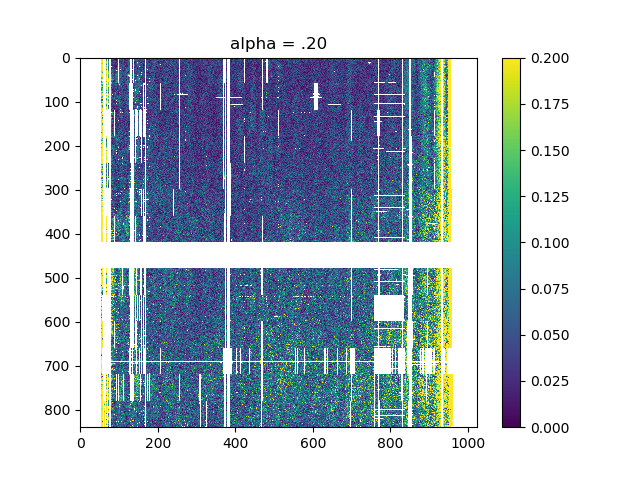

divide by zero encountered in divide
invalid value encountered in divide


In [64]:
ant = (124,'x')
plt.figure()
plt.imshow(np.abs(cs.gain_grids[ant] - gain_20) / (~cs.filtered_flag_grids[ant]) / np.abs(cs.gain_grids[ant]), aspect='auto')
plt.title('alpha = .20')
plt.clim([0,.2])
plt.colorbar()
plt.savefig('/Users/jsdillon/Desktop/20.png')

<IPython.core.display.Javascript object>


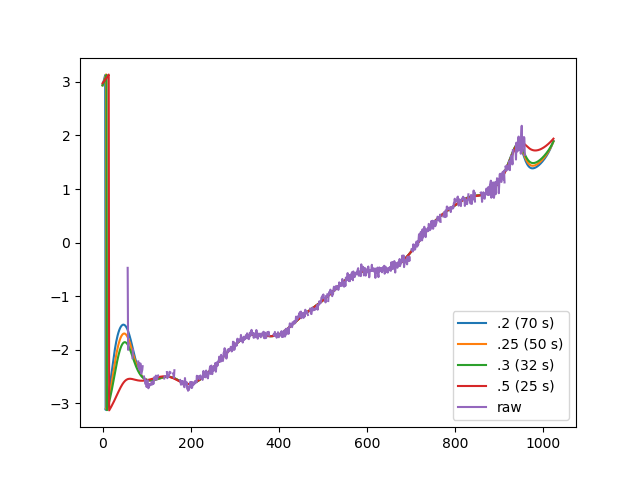

divide by zero encountered in divide
invalid value encountered in divide


<IPython.core.display.Javascript object>


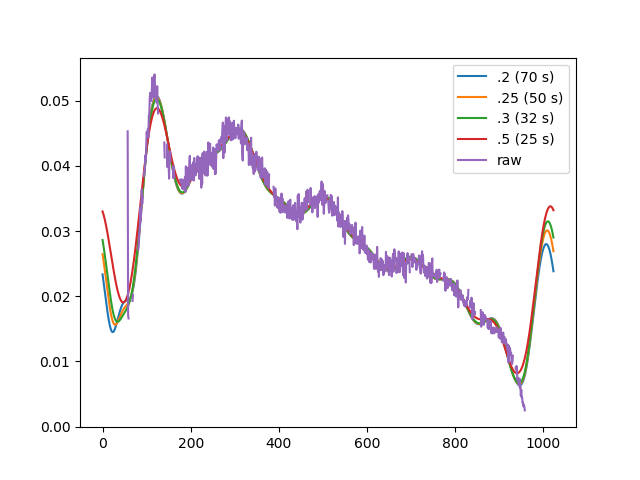

divide by zero encountered in divide


In [40]:
ant = (124,'x')
integration=500
plt.figure()
plt.plot((np.angle(gain_20))[integration,:], label='.2 (70 s)')
plt.plot((np.angle(gain_25))[integration,:], label='.25 (50 s)')
plt.plot((np.angle(gain_30))[integration,:], label='.3 (32 s)')
plt.plot((np.angle(gain_50))[integration,:], label='.5 (25 s)')
plt.plot((np.angle(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:], label='raw')
plt.legend()
         
plt.figure()
plt.plot((np.abs(gain_20))[integration,:], label='.2 (70 s)')
plt.plot((np.abs(gain_25))[integration,:], label='.25 (50 s)')
plt.plot((np.abs(gain_30))[integration,:], label='.3 (32 s)')
plt.plot((np.abs(gain_50))[integration,:], label='.5 (25 s)')
plt.plot((np.abs(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:], label='raw')
plt.legend()

<IPython.core.display.Javascript object>


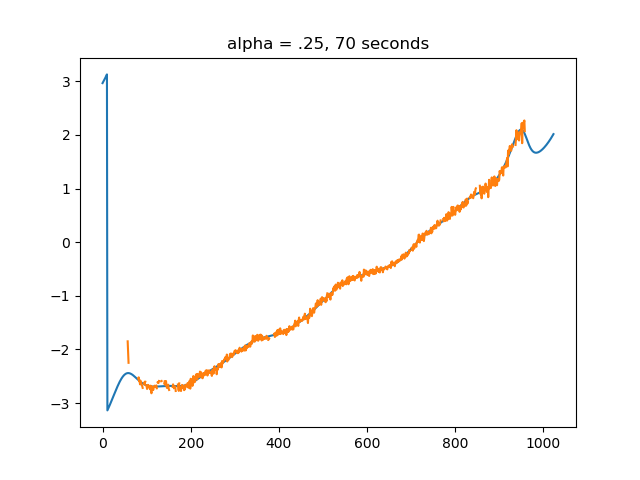

divide by zero encountered in divide
invalid value encountered in divide


<IPython.core.display.Javascript object>


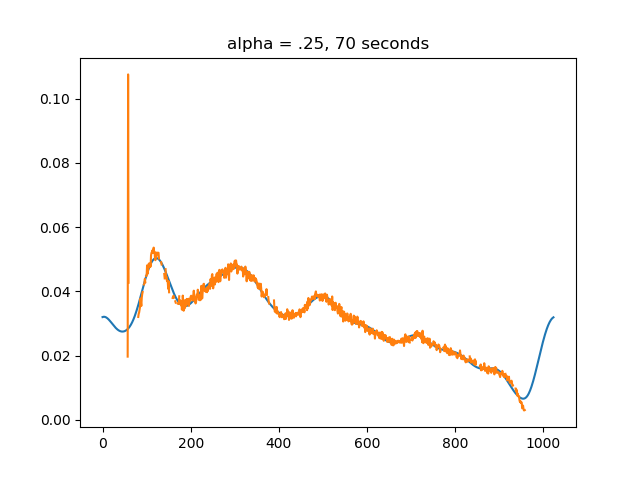

divide by zero encountered in divide


Text(0.5,1,u'alpha = .25, 70 seconds')

In [27]:
ant = (124,'x')
integration=300
plt.figure()
plt.plot((np.angle(cs.filtered_gain_grids[ant]))[integration,:])
plt.plot((np.angle(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:])
plt.title('alpha = .25, 50 seconds')
plt.figure()
plt.plot((np.abs(cs.filtered_gain_grids[ant]))[integration,:])
plt.plot((np.abs(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:])
plt.title('alpha = .25, 50 seconds')

<IPython.core.display.Javascript object>


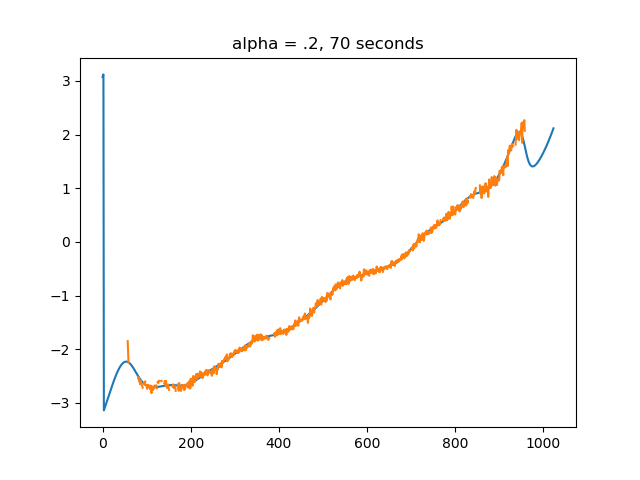

divide by zero encountered in divide
invalid value encountered in divide


<IPython.core.display.Javascript object>


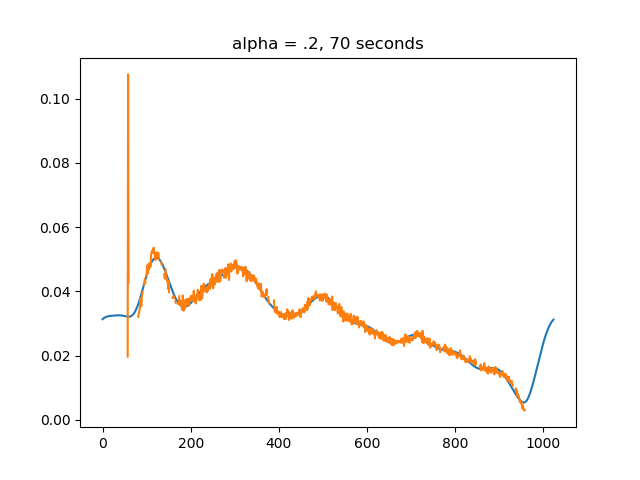

divide by zero encountered in divide


Text(0.5,1,u'alpha = .2, 70 seconds')

In [19]:
ant = (124,'x')
integration=300
plt.figure()
plt.plot((np.angle(cs.filtered_gain_grids[ant]))[integration,:])
plt.plot((np.angle(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:])
plt.title('alpha = .2, 70 seconds')
plt.figure()
plt.plot((np.abs(cs.filtered_gain_grids[ant]))[integration,:])
plt.plot((np.abs(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:])
plt.title('alpha = .2, 70 seconds')

<IPython.core.display.Javascript object>


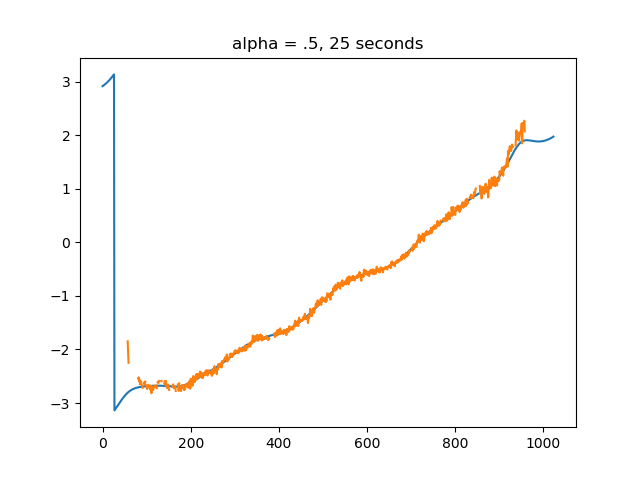

divide by zero encountered in divide
invalid value encountered in divide


<IPython.core.display.Javascript object>


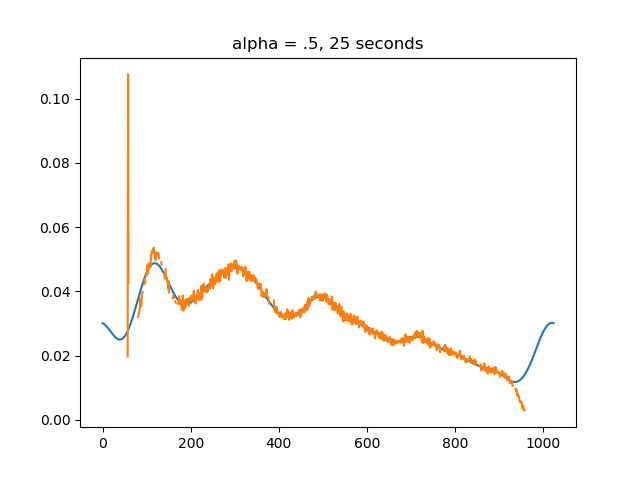

divide by zero encountered in divide


Text(0.5,1,u'alpha = .5, 25 seconds')

In [16]:
ant = (124,'x')
integration=300
plt.figure()
plt.plot((np.angle(cs.filtered_gain_grids[ant]))[integration,:])
plt.plot((np.angle(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:])
plt.title('alpha = .5, 25 seconds')
plt.figure()
plt.plot((np.abs(cs.filtered_gain_grids[ant]))[integration,:])
plt.plot((np.abs(cs.gain_grids[ant]) / (~cs.filtered_flag_grids[ant]))[integration,:])
plt.title('alpha = .5, 25 seconds')

<IPython.core.display.Javascript object>


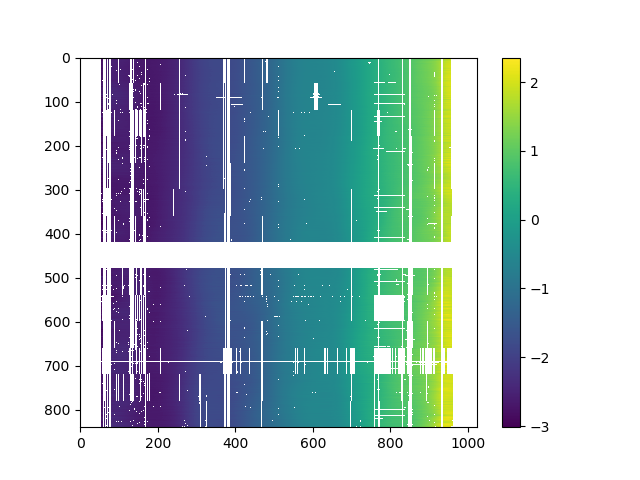

divide by zero encountered in divide
invalid value encountered in divide


In [17]:
ant = (124,'x')
plt.figure()
plt.imshow(np.angle(cs.filtered_gain_grids[ant]) / (~cs.filtered_flag_grids[ant]), aspect='auto')
#plt.imshow(np.angle(cs.filtered_gain_grids[ant]), aspect='auto')
plt.colorbar()

# for unit testing

In [75]:
uvOCRs = glob.glob('data/*.uvOCR')
for f in uvOCRs:
    uvd = UVData()
    uvd.read_miriad(f)
    uvd.select(antenna_nums=[53,54])
    uvd.write_miriad(f + '_53x_54x_only', clobber=True)
    antpos, ants = uvd.get_ENU_antpos(center=True, pick_data_ants=True)
    np.savez(f + '_53x_54x_only.flags.applied.npz', flag_array=uvd.flag_array, baseline_array=uvd.baseline_array,
             antpairs=uvd.get_antpairs(), polarization_array=uvd.polarization_array, 
             freq_array=uvd.freq_array, time_array=uvd.time_array, lst_array=uvd.lst_array, 
             antpos=antpos, ants=ants, history=uvd.history + '\n Josh Dillon manually extracted antennas 53 and 54 for unit testing on May 10, 2018')


File exists: clobbering
File exists: clobbering
File exists: clobbering


In [76]:
for f in uvOCRs:
    cal = f.replace('.uvOCR','.uv.abs.calfits')
    uvc = UVCal()
    uvc.read_calfits(cal)
    uvc.select(antenna_nums=[54])
    uvc.history += '\n Josh Dillon manually extracted antenna 54 for unit testing on May 10, 2018'
    uvc.write_calfits(cal+'_54x_only', clobber=True)

In [78]:
uvd.time_array.shape

(180,)

In [79]:
uvd = UVData()
uvd.read_miriad(uvOCRs[0])
